<a href="https://colab.research.google.com/github/nerobite/neural_networks/blob/main/DL_project_add.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [26]:
#Загружаем необходимые библиотеки
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
import datetime
import matplotlib.pyplot as plt

In [27]:
# Загружаем цены акций строительных компаний РФ за доступный период
df = pd.read_csv('/content/prices.csv')

In [28]:
# Преобразуем дату
df['date'] = pd.to_datetime(df['date'])

In [29]:
# Удаление выбросов с помощью IQR
def remove_outliers(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    data = data[(data[column] >= Q1 - 1.5 * IQR) & (data[column] <= Q3 + 1.5 * IQR)]
    return data

In [30]:
# Очистка данных (удаление выбросов)
for company_id in df['company_id'].unique():
    df.loc[df['company_id'] == company_id, 'close'] = remove_outliers(df[df['company_id'] == company_id], 'close')['close']

In [31]:
# Проверяем наличие пустых значений цены акций после удаления выбросов
df.loc[df['close'].isnull()]

,id,company_id,date,close,open,high,low,volume,adj_close
3524,0,24,2021-08-30,NaN,1335.0,1433.80,1315.5,1526210,1350.00
3525,0,24,2021-08-31,NaN,1368.5,1368.90,1331.2,308103,1345.90
3526,0,24,2021-09-01,NaN,1354.0,1372.00,1339.4,251136,1370.00
3527,0,24,2021-09-02,NaN,1375.0,1392.00,1360.6,326781,1383.00
3528,0,24,2021-09-03,NaN,1390.0,1400.00,1380.2,305391,1389.60
...,...,...,...,...,...,...,...,...,...
11642,0,87,2023-09-08,NaN,322.9,327.25,294.0,493260,313.60
11643,0,87,2023-09-11,NaN,313.6,325.00,303.8,309080,311.30
11644,0,87,2023-09-12,NaN,312.0,324.90,312.0,285850,315.25
11645,0,87,2023-09-13,NaN,316.0,325.00,308.8,316920,312.60


In [32]:
# Заполнение NaN значений предыдущими значениями (forward fill)
df['close'] = df['close'].ffill()

In [33]:
# Нормализация данных
scaler = MinMaxScaler(feature_range=(0, 1))
df['scaled_close'] = scaler.fit_transform(df[['close']])

In [34]:
# Создание последовательностей для LSTM, берем интервалы рывные 30 значений цены акции
sequence_length = 60
X, y = [], []
for company_id in df['company_id'].unique():
    company_data = df[df['company_id'] == company_id]['scaled_close'].values
    for i in range(sequence_length, len(company_data)):
        X.append(company_data[i-sequence_length:i])
        y.append(company_data[i])

In [35]:
# Преобразуем списки в массивы numpy
X, y = np.array(X), np.array(y)

In [36]:
# Разделение данных на обучающую и тестовую выборки
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [37]:
from keras.models import Sequential
from keras.layers import LSTM, BatchNormalization, Dropout, Dense, Input

# Создаем модель
model = Sequential()

# Добавляем Input слой с указанием input_shape
model.add(Input(shape=(30, 1)))  # Это указывает форму входных данных

# Добавляем LSTM слои и другие необходимые слои
model.add(LSTM(units=1000, return_sequences=True))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(LSTM(units=1000, return_sequences=True))
model.add(BatchNormalization())
model.add(Dropout(0.5))


model.add(LSTM(units=50))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(units=1))

In [38]:
# Проверка на NaN или бесконечные значения в тренировочном и тестовом наборах
print("NaN in X_train:", np.isnan(X_train).any())
print("NaN in y_train:", np.isnan(y_train).any())
print("NaN in X_test:", np.isnan(X_test).any())
print("NaN in y_test:", np.isnan(y_test).any())

print("Inf in X_train:", np.isinf(X_train).any())
print("Inf in y_train:", np.isinf(y_train).any())
print("Inf in X_test:", np.isinf(X_test).any())
print("Inf in y_test:", np.isinf(y_test).any())

NaN in X_train: False
NaN in y_train: False
NaN in X_test: False
NaN in y_test: False
Inf in X_train: False
Inf in y_train: False
Inf in X_test: False
Inf in y_test: False


In [39]:
# Проверяем максимальные и минимальные значения после нормализации
print("X_train range:", X_train.min(), X_train.max())
print("y_train range:", y_train.min(), y_train.max())

X_train range: 0.0 0.2297687024200499
y_train range: 0.0 0.2297687024200499


In [40]:
from keras.callbacks import EarlyStopping
# Связи с ограниченными вычислительными ресурсами,
# прекращаем обучение, когда отслеживаемый показатель перестанет улучшаться.
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model.compile(optimizer=Adam(learning_rate=0.001, clipnorm=1.0), loss='mean_squared_error')

# Проверка модели
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_3 (LSTM)                        │ (None, 30, 1000)            │       4,008,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 30, 1000)            │           4,000 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 30, 1000)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_4 (LSTM)                        │ (None, 30, 1000)            │       8,004,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 30, 1000)            │           4,000 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 30, 1000)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_5 (LSTM)                        │ (None, 50)                  │         210,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 50)                  │             200 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 12,230,451 (46.66 MB)

 Trainable params: 12,226,351 (46.64 MB)

 Non-trainable params: 4,100 (16.02 KB)

In [41]:
# Обучение модели
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stop])

Epoch 1/50
346/346 ━━━━━━━━━━━━━━━━━━━━ 32s 83ms/step - loss: 0.7814 - val_loss: 0.4992
Epoch 2/50
346/346 ━━━━━━━━━━━━━━━━━━━━ 40s 80ms/step - loss: 0.0031 - val_loss: 0.0875
Epoch 3/50
346/346 ━━━━━━━━━━━━━━━━━━━━ 28s 80ms/step - loss: 0.0148 - val_loss: 0.1911
Epoch 4/50
346/346 ━━━━━━━━━━━━━━━━━━━━ 41s 80ms/step - loss: 0.0031 - val_loss: 0.0580
Epoch 5/50
346/346 ━━━━━━━━━━━━━━━━━━━━ 41s 81ms/step - loss: 0.0012 - val_loss: 0.0595
Epoch 6/50
346/346 ━━━━━━━━━━━━━━━━━━━━ 41s 80ms/step - loss: 8.5508e-04 - val_loss: 0.0516
Epoch 7/50
346/346 ━━━━━━━━━━━━━━━━━━━━ 41s 81ms/step - loss: 8.0398e-04 - val_loss: 0.0506
Epoch 8/50
346/346 ━━━━━━━━━━━━━━━━━━━━ 41s 80ms/step - loss: 7.5674e-04 - val_loss: 0.0449
Epoch 9/50
346/346 ━━━━━━━━━━━━━━━━━━━━ 41s 81ms/step - loss: 7.4727e-04 - val_loss: 0.0589
Epoch 10/50
346/346 ━━━━━━━━━━━━━━━━━━━━ 41s 80ms/step - loss: 6.9259e-04 - val_loss: 0.0553
Epoch 11/50
346/346 ━━━━━━━━━━━━━━━━━━━━ 41s 80ms/step - loss: 6.6854e-04 - val_loss: 0.0422
Epoch 

In [76]:
X_train.shape

(11052, 60)

In [42]:
# Сохраняем обученую модель
model.save('DL_project_lstm_power.keras')

In [43]:
# Оценка на тестовой выборке
test_loss = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}")

87/87 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0093
Test Loss: 0.00732283154502511


In [44]:
# Mean Absolute Percentage Error (MAPE)
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Пример использования
y_pred = model.predict(X_test)  # Предсказания модели
mape = mean_absolute_percentage_error(y_test, y_pred)
print(f"MAPE: {mape}%")
# Данный показатель больше 100%, что не корректно и MAPE в задачах временныъ рядов часто заменяют на MAE

87/87 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step
MAPE: 1261.5548845319727%


In [45]:
# MAE (Mean Absolute Error)
from sklearn.metrics import mean_absolute_error

mae = mean_absolute_error(y_test, y_pred)
print(f"MAE: {mae}")


MAE: 0.07829042590335376


In [46]:
# RMSE (Root Mean Squared Error)
from sklearn.metrics import mean_squared_error

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"RMSE: {rmse}")

RMSE: 0.08557354959845163


In [47]:
data = df.copy()

In [48]:
#Получение уникальных компаний
unique_companies = data['company_id'].unique()
unique_companies

array([  24,   42,   87,  190, 4982])

In [49]:
# Загрузка модели
# model = load_model('/content/DL_project_lstm_power.keras')

In [79]:
input_data = scaled_prices[-30:].reshape(1, -1, 1)
# predicted_scaled = model.predict(input_data)

In [80]:
input_data[0][1]

array([0.4704314])

In [85]:
a = scaled_prices[-60:].reshape(1, -1)
a.shape

(1, 60)

In [87]:
results = []  # Итоговый список предсказаний

for company_id in unique_companies:
    # Фильтрация данных для компании
    company_data = data[data['company_id'] == company_id]

    # Убедимся, что данные компании непустые
    if company_data.empty:
        print(f"Пропускаем компанию {company_id}, данные отсутствуют")
        continue

    # Предобработка данных
    company_data['date'] = pd.to_datetime(company_data['date'])  # Преобразуем дату
    company_data.sort_values('date', inplace=True)              # Сортировка по дате
    prices = company_data['close'].values.reshape(-1, 1)

    # Определение последней известной даты
    last_known_date = company_data['date'].max()

    # Масштабирование цен
    scaler = MinMaxScaler()
    scaled_prices = scaler.fit_transform(prices)

    # Подготовка последних 30 точек для первого предсказания
    if len(scaled_prices) < 30:
        print(f"Пропускаем компанию {company_id}, данных меньше 30")
        continue

    input_data = scaled_prices[-30:].reshape(1, -1)

    # Итеративное прогнозирование на 30 дней
    predictions = []
    current_date = last_known_date  # Установим дату на последнюю известную дату
    for i in range(30):
        # Предсказание модели
        print(i)
        predicted_scaled = model.predict(input_data)
        predicted = scaler.inverse_transform(predicted_scaled)  # Обратное масштабирование

        # Обновляем дату прогноза
        current_date += datetime.timedelta(days=1)

        # Сохраняем предсказание
        predictions.append({'company_id': company_id,
                            'date': current_date,
                            'predicted_price': predicted[0, 0]})

        # Обновление входных данных
        input_data = np.append(input_data[0][1:], predicted_scaled).reshape(1, -1)

    # Сохранение результата для компании
    results.extend(predictions)

# Конвертация в DataFrame для анализа
results_df = pd.DataFrame(results)


0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


<ipython-input-87-cee4bd9afcf7>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  company_data['date'] = pd.to_datetime(company_data['date'])  # Преобразуем дату
<ipython-input-87-cee4bd9afcf7>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  company_data.sort_values('date', inplace=True)              # Сортировка по дате


3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
7
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
8
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
9
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
11
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
12
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
13
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
14
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
16
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
17
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
18
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
19
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
21
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
22
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
23
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
26
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
27
1/1 ━━━━━━━━━━━━━━━━

<ipython-input-87-cee4bd9afcf7>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  company_data['date'] = pd.to_datetime(company_data['date'])  # Преобразуем дату
<ipython-input-87-cee4bd9afcf7>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  company_data.sort_values('date', inplace=True)              # Сортировка по дате


3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
7
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
8
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
9
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
11
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
12
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
13
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
14
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
16
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
17
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
18
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
19
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
21
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
22
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
23
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
26
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
27
1/1 ━━━━━━━━━━━━━━━━

<ipython-input-87-cee4bd9afcf7>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  company_data['date'] = pd.to_datetime(company_data['date'])  # Преобразуем дату
<ipython-input-87-cee4bd9afcf7>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  company_data.sort_values('date', inplace=True)              # Сортировка по дате


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
7
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
8
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
9
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
11
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
12
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
13
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
14
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
16
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
17
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
18
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
19
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
21
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
22
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
23
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
26
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
27
1/1 ━━━━━━━━━━━━━━━━━━

<ipython-input-87-cee4bd9afcf7>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  company_data['date'] = pd.to_datetime(company_data['date'])  # Преобразуем дату
<ipython-input-87-cee4bd9afcf7>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  company_data.sort_values('date', inplace=True)              # Сортировка по дате


3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
7
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
8
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
9
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
11
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
12
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
13
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
14
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
16
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
17
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
18
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
19
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
21
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
22
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
23
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
26
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
27
1/1 ━━━━━━━━━━━━━━━━

<ipython-input-87-cee4bd9afcf7>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  company_data['date'] = pd.to_datetime(company_data['date'])  # Преобразуем дату
<ipython-input-87-cee4bd9afcf7>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  company_data.sort_values('date', inplace=True)              # Сортировка по дате


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
7
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
8
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
9
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
11
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
12
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
13
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
14
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
16
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
17
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
18
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
19
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
21
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
22
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
23
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
26
1/1 ━━━━━━━━━━━━━━━━━━━

In [88]:
print(results_df)

     company_id       date  predicted_price
0            24 2024-10-12       607.587830
1            24 2024-10-13       603.690247
2            24 2024-10-14       596.855957
3            24 2024-10-15       590.272278
4            24 2024-10-16       582.850769
..          ...        ...              ...
145        4982 2024-11-06      1431.102173
146        4982 2024-11-07      1441.274536
147        4982 2024-11-08      1450.831787
148        4982 2024-11-09      1459.840820
149        4982 2024-11-10      1467.617798

[150 rows x 3 columns]


In [89]:
results_df.loc[results_df['company_id'] == 4982]

,company_id,date,predicted_price
120,4982,2024-10-12,1733.764282
121,4982,2024-10-13,1712.893066
122,4982,2024-10-14,1679.302368
123,4982,2024-10-15,1647.747314
124,4982,2024-10-16,1616.464355
125,4982,2024-10-17,1585.930054
126,4982,2024-10-18,1558.941040
127,4982,2024-10-19,1533.627441
128,4982,2024-10-20,1511.236938
129,4982,2024-10-21,1486.955200


In [90]:
# Загружаем реальные цены на прогнозируемый период
real_price = pd.read_csv('/content/real_price.csv')

In [91]:
real_price = real_price[['company_id', 'date', 'close']]

In [92]:
# Преобразуем столбец 'date' в datetime в обоих DataFrame
real_price['date'] = pd.to_datetime(real_price['date'])
results_df['date'] = pd.to_datetime(results_df['date'])

# Теперь можно выполнять слияние
price_comparison = pd.merge(results_df, real_price, on=['company_id', 'date'], how='inner')

In [93]:
price_comparison.head()

,company_id,date,predicted_price,close
0,24,2024-10-14,596.855957,647.5
1,24,2024-10-15,590.272278,652.9
2,24,2024-10-16,582.850769,643.0
3,24,2024-10-17,574.587708,637.4
4,24,2024-10-18,567.416138,636.3


In [94]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

In [95]:
y_true = price_comparison['close']  # Реальные цены
y_pred = price_comparison['predicted_price']  # Предсказанные цены

# RMSE
rmse = np.sqrt(mean_squared_error(y_true, y_pred))

# MAE
mae = mean_absolute_error(y_true, y_pred)

# MAPE
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# R2
r2 = r2_score(y_true, y_pred)

# Выводим результаты
print(f'RMSE: {rmse}')
print(f'MAE: {mae}')
print(f'MAPE: {mape}%')
print(f'R^2: {r2}')

RMSE: 105.17579092289824
MAE: 68.29464180297852
MAPE: 11.439382545107007%
R^2: 0.9635922863029106


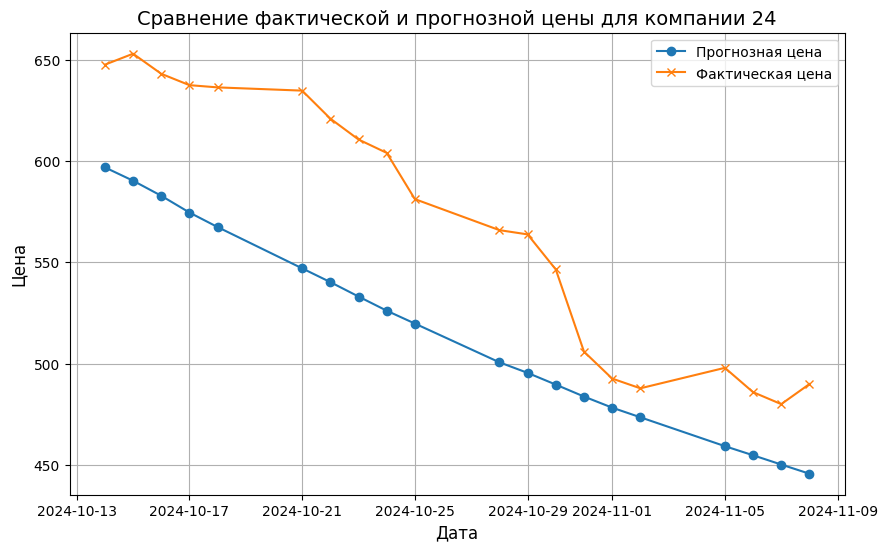

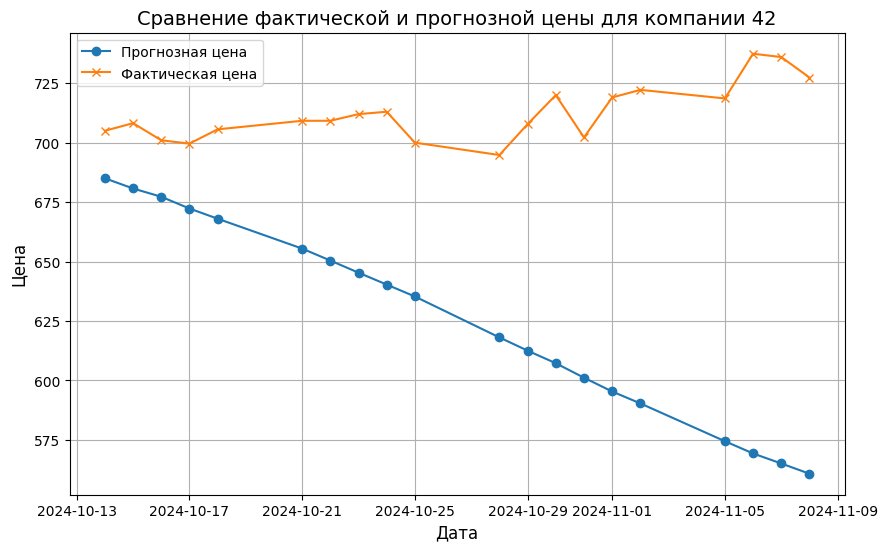

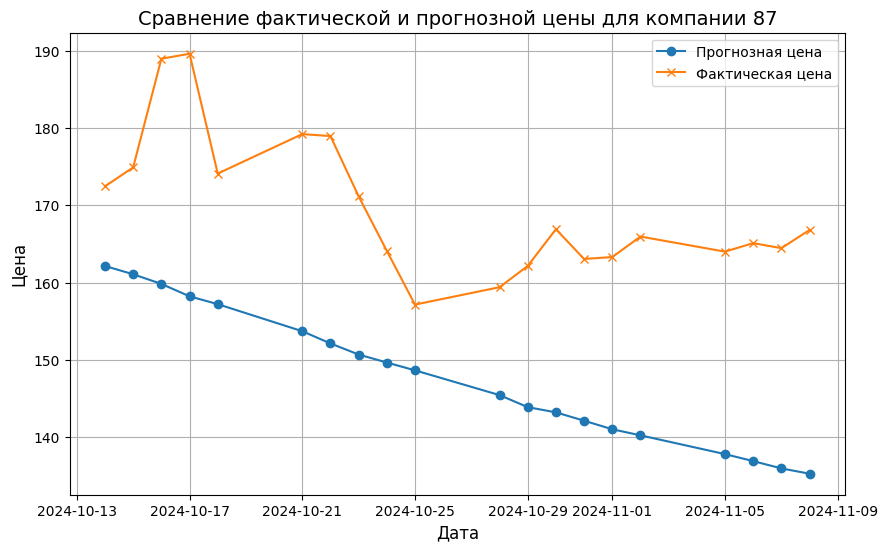

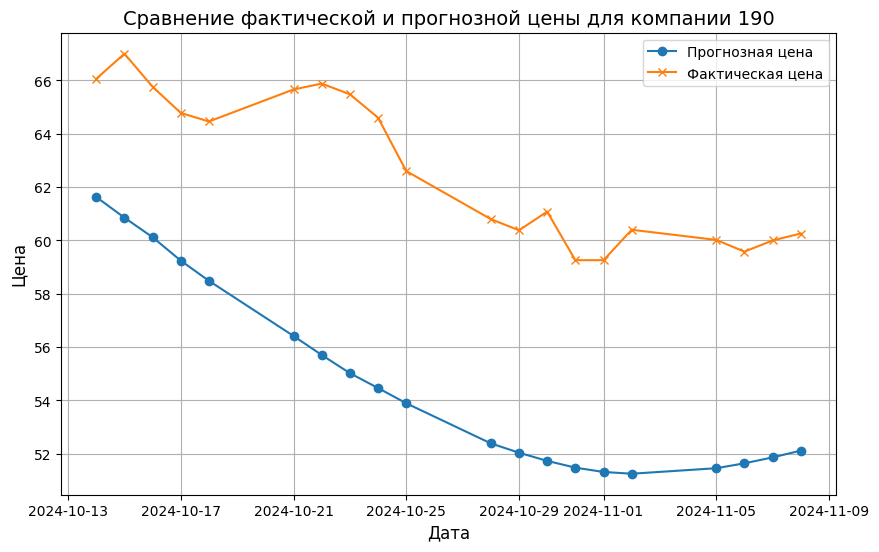

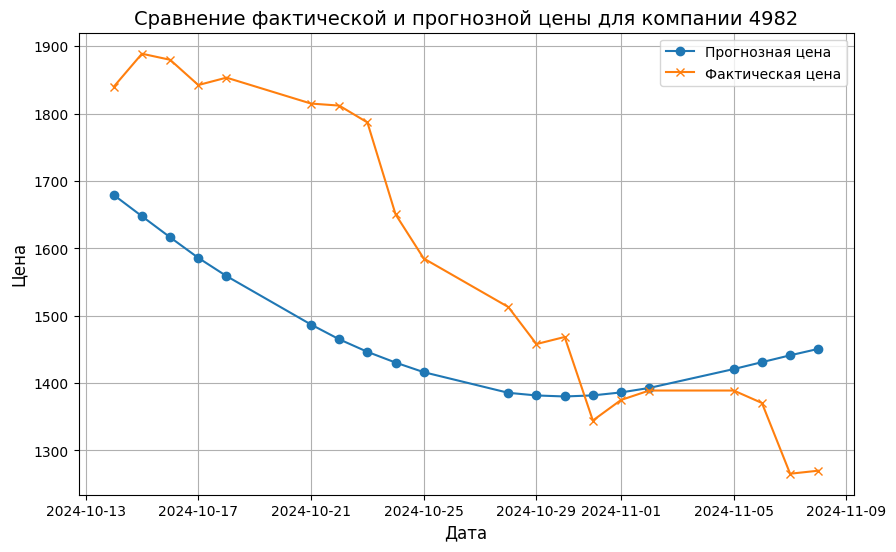

In [96]:
# Группировка данных по компаниям и построение графика для каждой компании
unique_companies = price_comparison["company_id"].unique()

for company_id in unique_companies:
    company_data = price_comparison[price_comparison["company_id"] == company_id]

    plt.figure(figsize=(10, 6))
    plt.plot(company_data["date"], company_data["predicted_price"], label="Прогнозная цена", marker='o')
    plt.plot(company_data["date"], company_data["close"], label="Фактическая цена", marker='x')
    plt.title(f"Сравнение фактической и прогнозной цены для компании {company_id}", fontsize=14)
    plt.xlabel("Дата", fontsize=12)
    plt.ylabel("Цена", fontsize=12)
    plt.legend()
    plt.grid(True)
    plt.show()